# 1. Configuration and Importing Libraries

In [25]:
DATA_PATH = ".heart.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.3

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc

from catboost import CatBoostClassifier

import joblib

# 2. Preprocessing

In [30]:
def load_data(file_path):
    return pd.read_csv(file_path)

df = load_data("./heart.csv")
df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [32]:
for feature in df.columns:
    if df[feature].dtype == 'object':
        unique_values = df[feature].unique() 
        print(feature, unique_values)

Sex ['M' 'F']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
RestingECG ['Normal' 'ST' 'LVH']
ExerciseAngina ['N' 'Y']
ST_Slope ['Up' 'Flat' 'Down']


In [33]:
data = df.copy()

data.Sex = (data.Sex == 'M').astype(int)
data.ExerciseAngina = (data.ExerciseAngina == 'Y').astype(int)

chest_pain = pd.get_dummies(data.ChestPainType, prefix="chest_pain")
for i in chest_pain:
    chest_pain[i] = chest_pain[i].map({True: 1, False: 0})

resting_ecg = pd.get_dummies(data.RestingECG, prefix="restingECG")
for i in resting_ecg:
    resting_ecg[i] = resting_ecg[i].map({True: 1, False: 0})

st_slope = pd.get_dummies(data.ST_Slope, prefix="st_slope")
for i in st_slope:
    st_slope[i] = st_slope[i].map({True: 1, False: 0})

data = data.drop(["ChestPainType", "RestingECG", "ST_Slope"], axis=1)

for i in chest_pain, resting_ecg, st_slope:
    data = pd.concat((data, i), axis=1)

In [34]:
data

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,chest_pain_ASY,chest_pain_ATA,chest_pain_NAP,chest_pain_TA,restingECG_LVH,restingECG_Normal,restingECG_ST,st_slope_Down,st_slope_Flat,st_slope_Up
0,40,1,140,289,0,172,0,0.0,0,0,1,0,0,0,1,0,0,0,1
1,49,0,160,180,0,156,0,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,1,130,283,0,98,0,0.0,0,0,1,0,0,0,0,1,0,0,1
3,48,0,138,214,0,108,1,1.5,1,1,0,0,0,0,1,0,0,1,0
4,54,1,150,195,0,122,0,0.0,0,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,110,264,0,132,0,1.2,1,0,0,0,1,0,1,0,0,1,0
914,68,1,144,193,1,141,0,3.4,1,1,0,0,0,0,1,0,0,1,0
915,57,1,130,131,0,115,1,1.2,1,1,0,0,0,0,1,0,0,1,0
916,57,0,130,236,0,174,0,0.0,1,0,1,0,0,1,0,0,0,1,0


In [37]:
X = data.drop(["HeartDisease"], axis=1)
y = data["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=TEST_SIZE)

X_train.shape, X_test.shape

((642, 18), (276, 18))

# 3. Model Training & Evaluation

### **Model 1**

In [39]:
model_1 = CatBoostClassifier(
    iterations = 100,
    learning_rate = 0.1,
    depth = 3,
    verbose=False
)

model_1.fit(X_train, y_train)

In [67]:
importances = model_1.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
feature_imp_df

,Feature,Gini Importance
17,st_slope_Up,29.278742
8,chest_pain_ASY,12.721242
7,Oldpeak,11.748417
3,Cholesterol,8.027797
6,ExerciseAngina,7.997671
16,st_slope_Flat,6.658647
1,Sex,5.732608
0,Age,5.671569
4,FastingBS,3.463360
5,MaxHR,3.378985


In [59]:
preds = model_1.predict(X_test)


accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, preds))
pd.crosstab(y_test, preds)

Accuracy: 0.8876811594202898
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       112
           1       0.92      0.89      0.90       164

    accuracy                           0.89       276
   macro avg       0.88      0.89      0.88       276
weighted avg       0.89      0.89      0.89       276



col_0,0,1
HeartDisease,,
0,99,13
1,18,146


### **Model 2**

In [ ]:
param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 250, 500]
}

grid_search = GridSearchCV(estimator=model_1, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001BFD4B85C10>,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [100, 250, 500],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='accuracy')

In [65]:
print(grid_search.best_params_)

{'depth': 6, 'iterations': 100, 'learning_rate': 0.1}


In [51]:
model_2 = CatBoostClassifier(
    iterations = 100,
    learning_rate = 0.1,
    depth = 6,
    verbose=False
)

model_2.fit(X_train, y_train)

In [60]:
preds2 = model_2.predict(X_test)

accuracy = accuracy_score(y_test, preds2)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, preds2))
pd.crosstab(y_test, preds2)

Accuracy: 0.8913043478260869
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       112
           1       0.92      0.89      0.91       164

    accuracy                           0.89       276
   macro avg       0.89      0.89      0.89       276
weighted avg       0.89      0.89      0.89       276



col_0,0,1
HeartDisease,,
0,100,12
1,18,146


In [68]:
importances = model_2.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
feature_imp_df

,Feature,Gini Importance
17,st_slope_Up,27.853051
7,Oldpeak,11.602699
8,chest_pain_ASY,9.993775
3,Cholesterol,7.675579
0,Age,6.704824
5,MaxHR,6.660582
16,st_slope_Flat,5.622362
6,ExerciseAngina,5.442630
1,Sex,5.389014
2,RestingBP,5.253142


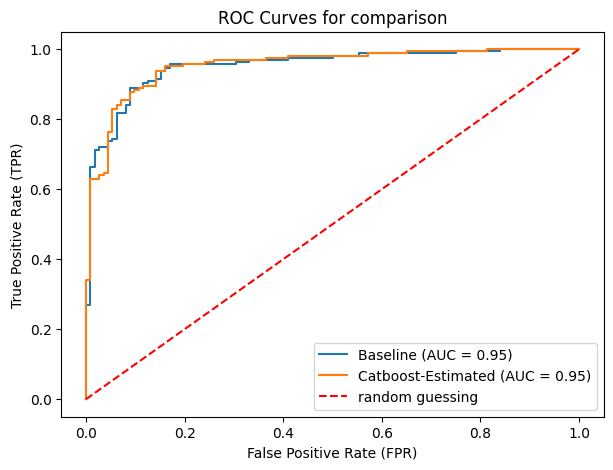

In [61]:
model_1_res = model_1.predict_proba(X_test)[:, 1]
model_2_res = model_2.predict_proba(X_test)[:, 1]

testing_clmod = pd.DataFrame(
    {
        'True': y_test, 'Baseline': model_1_res, 'Catboost-Estimated': model_2_res
    })

plt.figure(figsize=(7, 5))
for model in ['Baseline', 'Catboost-Estimated']:
    fpr, tpr, _ = roc_curve(testing_clmod['True'], testing_clmod[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='random guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for comparison')
plt.legend()
plt.show()

In [70]:
joblib.dump(model_2, "catboost-estimated-model")

['catboost-estimated-model']

In [74]:
data.to_csv("data_processed.csv")